<h1><b>TESTS</b>
</h1>

<b>MSE (Mean Square Error)</b>
<br>
The lower, the better. Indicates the amount of noise contained within a picture.
<br>
<br>
$ MSE = \frac{\sum_{m,n} [I_1(m,n)-I_2(m,n)]^{2}}{M \cdot N} $ 
<br>
<br>
<br>
<b>PSNR (Peak Signal to Noise Ratio)</b>
<br>
The higher, the better. Indicates the maximum amount of noise relative to the picture.
<br>
<br>
$ PSNR = 10\log_{10} \left(\frac{R^2}{MSE}\right) $ 

In [10]:
# MSE
from PIL import Image
import numpy as np
from FFT_stego import convert, stego_path_generator

# cover_img_path = "ImageSources\\jfif\\darth_vader.jfif"
# cover_img_path = "ImageSources\\jfif\\the_rock.jfif"
# cover_img_path = "ImageSources\\jfif\\obi-wan_kenobi.jfif"
# PATH = "ImageSources\\png\\r2d2.png"
# cover_img_path = "ImageSources\\jpg\\iron_patriot.jpg"
cover_img_path = "ImageSources\\tif\\lena_color_256.tif"
# stego_img_path = "ImageSources\\Steganograms\\remerged_sharp.png"
stego_img_path = "ImageSources\\Steganograms\\lena_color_256_steg.png"

# stego_img_path = stego_path_generator(cover_img_path, "png")

image0 = Image.open(cover_img_path)
red0, green0, blue0 = image0.split()
image1 = Image.open(stego_img_path)
red1, green1, blue1 = image1.split()

red0 = np.array(red0)

# takes into account the error that occurs when transforming the channel to the frequency domain
def fft_correction(channel, clip: bool=False):
    fft = np.fft.fft2(channel)
    ifft = np.fft.ifft2(np.abs(fft)*np.exp(1j*np.angle(fft))).real
    if clip:
        converted = np.clip(ifft, 0,255).astype(np.uint8)
    else:
        converted = convert(ifft, 0,255, np.uint8)
    return converted

# red0 = fft_correction(red0)

red1 = np.array(red1)

cols, rows = red0.shape


mse = np.divide(np.sum(np.square(np.subtract(red0, red1))), np.multiply(*(red0.shape)))
print("MSE = ", mse)

psnr = 20*np.log10(255) - 10*np.log10(mse)
print("PSNR =", psnr, "db")

MSE =  2.5104522705078125
PSNR = 44.13328392019576 db


<h2>CROP</h2>

(256, 256)


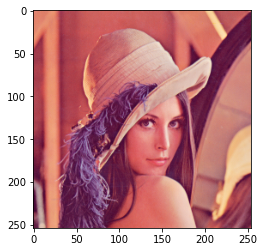

In [14]:
from PIL import Image
import matplotlib.pyplot as plt
from FFT_stego import crop_path_generator, stego_path_generator

# cover_img_path = "ImageSources\\jpg\\lena_color_256.tif"
# stego_img_path = stego_path_generator(cover_img_path, "png")
stego_img_path = "ImageSources\\Steganograms\\lena_color_256_steg.png"

image = Image.open(stego_img_path)
size = image.size
print(size)

crop = 0.01  # crop 50%
crop /= 2

# left, up , right, bottom
# crop the image
cropped = image.crop((round(size[0]*crop),round(size[1]*crop), round(size[0]*(1-crop)),round(size[1]*(1-crop))))

# generates the path for the stego image from the name of the cover image and the path the current python file resides on

crop_img_path = crop_path_generator(stego_img_path, "png")
plt.figure()
plt.imshow(cropped)


cropped.save(crop_img_path)

<h2>Resize</h2>

In [31]:
from PIL import Image
from FFT_stego import resize_path_generator

stego_img_path = "ImageSources\\Steganograms\\lena_color_256_steg.png"

steg = Image.open(stego_img_path)
cols, rows = steg.size

grow_factor = 1.005
steg_resize = steg.resize((round(rows/grow_factor), round(cols/grow_factor)))

resize_img_path = resize_path_generator(stego_img_path, "png")
steg_resize.save(resize_img_path)

<h2>Decoder</h2>

In [32]:
from FFT_stego import steg_decode_simple

stego_img_path = "ImageSources\\Steganograms\\lena_color_256_steg_resize.png"
# stego_img_path = "ImageSources\\Steganograms\\remerged_sharp.png"

parsed_text = steg_decode_simple(stego_img_path)
print(parsed_text)

Lorem ipsum dolor sit amet, consetetur sadipscing elitr, sed diam nonumy eirmod tempor invidunt ut labore et dolore magna aliquyam erat, sed diam voluptua.
At vero eos et accusam et justo duo dolores et ea rebum. Stet clita kasd gubergren, no sea takimata sanctus est Lorem ipsum dolor sit amet.
Lorem ipsum dolor sit amet, consetetur sadipscing elitr, sed diam nonumy eirmod tempor invidunt ut labore et dolore magna aliquyam erat, sed diam voluptua.
At vero eos et accusam et justo duo dolores et ea rebum. Stet clita kasd gubergren, no sea takimata sanctus est Lorem ipsum dolor sit amet.


<h2>Absolute FFT</h2>

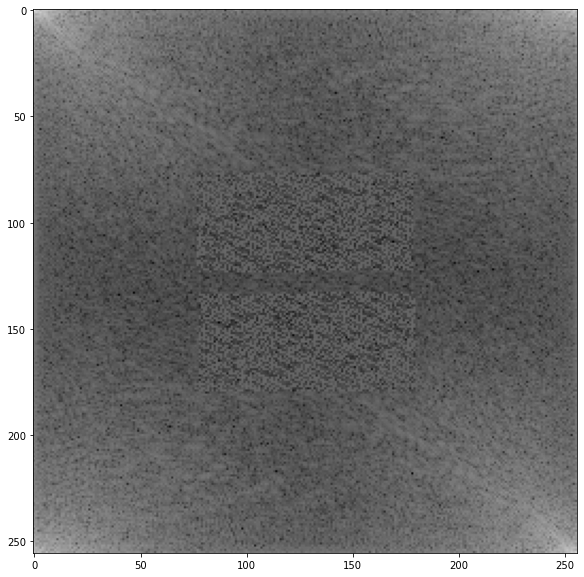

In [33]:
import numpy as np
import matplotlib.pyplot as plt

img_path = "ImageSources\\Steganograms\\lena_color_256_steg_resize.png"

image = Image.open(img_path)
red, green, blue = image.split()
fft_abs = 10*np.log10(np.abs(np.fft.fft2(red)))

plt.figure(figsize=(10,10))
plt.imshow(fft_abs, cmap="gray")